In [1]:
%reset # clears variables in workspace

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np

from IPython.display import display #for pretty printing

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

# create the model
m = ConcreteModel()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


In [2]:
N = 30 # how many points are in the trajectory
hm = 0.5/N #scaling factor
m.N = RangeSet(N) # For defining ordered/numerical sets. Works like 'range' in python.

m.g = Param(initialize = 9.81)
m.X0 = Param(initialize = 0.0) # position of fixed base
m.Z0 = Param(initialize = 1.0)
# m.h = Param(initialize = 0.02) # time step

# mass of links
m.m1 = Param(initialize = 0.35)
m.m2 = Param(initialize = 0.15)
m.m3 = Param(initialize = 0.35)
m.m4 = Param(initialize = 0.15)

mbody = m.m1.value+m.m2.value+m.m3.value+m.m4.value
mBW = mbody*m.g.value

# length of links
m.l1 = Param(initialize = 0.12) 
m.l2 = Param(initialize = 0.24) 
m.l3 = Param(initialize = 0.12) 
m.l4 = Param(initialize = 0.24) 
# IMPORTANT make sure your values are declared as floats: many a long debugging session has eventually led me to find something
# unexpectedly has a value of zero because of integer devision gone wrong. Goddamn implicit typing fuuuuuuuuuuuuuuuuuuuuuuuuuuu

#Inertia
m.In1= Param(initialize = m.m1.value*m.l1.value**2/12) 
m.In2= Param(initialize = m.m2.value*m.l2.value**2/12)
m.In3= Param(initialize = m.m3.value*m.l3.value**2/12)
m.In4= Param(initialize = m.m4.value*m.l4.value**2/12)

#Forces
m.t_max=6.864655 #Nm, corresponding to a 8V input
m.w_max=8.055366 #rad/s, corresponding to a 8V inpuy

print("Done")

Done


In [3]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
X0,Z0 = sym.symbols(['X0','Z0']) # fixed position of first link
m1,m2,m3,m4 = sym.symbols(['m1','m2','m3','m4']) # mass of links
l1,l2,l3,l4 = sym.symbols(['l1','l2','l3','l4']) # length of links
In1,In2,In3,In4 = sym.symbols(['In1','In2','In3','In4']) # moment of intertia of links

# generalized coordinates
x,z,th1,th2,th3,th4 = sym.symbols(['x','z','theta1','theta2','theta3','theta4']) #position
dx,dz,dth1,dth2,dth3,dth4 = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{1}','\dot{\\theta}_{2}','\dot{\\theta}_{3}','\dot{\\theta}_{4}']) #velocity
ddx,ddz,ddth1,ddth2,ddth3,ddth4 = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{1}','\ddot{\\theta}_{2}','\ddot{\\theta}_{3}','\ddot{\\theta}_{4}']) #acceleration

q = sym.Matrix([[th1],[th2],[th3],[th4]]) #group into matrices
dq = sym.Matrix([[dth1],[dth2],[dth3],[dth4]])
ddq = sym.Matrix([[ddth1],[ddth2],[ddth3],[ddth4]])

# forces
tau1,tau2,tau3,tau4 = sym.symbols(['\\tau_1','\\tau_2','\\tau_3','\\tau_4']) 

print('Done')

Done


In [4]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

x1 = X0 + 0.5*l1*sym.sin(th1)
z1 = Z0 - 0.5*l1*sym.cos(th1)

x2 = X0 + l1*sym.sin(th1) + 0.5*l2*sym.sin(th1+th2)
z2 = Z0 - l1*sym.cos(th1) - 0.5*l2*sym.cos(th1+th2)

x3 = X0 + 0.5*l3*sym.sin(th3)
z3 = Z0 - 0.5*l3*sym.cos(th3)

x4 = X0 + l3*sym.sin(th3) + 0.5*l4*sym.sin(th3+th4)
z4 = Z0 - l3*sym.cos(th3) - 0.5*l4*sym.cos(th3+th4)

print('Done')

Done


In [5]:
# STEP 2: generate expressions for the system space velocities
p1 = sym.Matrix([x1,z1])
v1 = p1.jacobian(q)*dq
[dx1,dz1] = v1

p2 = sym.Matrix([x2,z2])
v2 = p2.jacobian(q)*dq
[dx2,dz2] = v2 

p3 = sym.Matrix([x3,z3])
v3 = p3.jacobian(q)*dq
[dx3,dz3] = v3 

p4 = sym.Matrix([x4,z4])
v4 = p4.jacobian(q)*dq
[dx4,dz4] = v3 

print('Done')

Done


In [6]:
# STEP 3: generate expressions for the kinetic and potential energy

#Stacy Shield's method
# T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
# V = sym.Matrix([m1*g*y1 + m2*g*y2])

#Callen Fisher's method, better for bigger problems.
M1 = sym.Matrix([[m1,m1]])
M2 = sym.Matrix([[m2,m2]])
M3 = sym.Matrix([[m3,m3]])
M4 = sym.Matrix([[m4,m4]])

I1=sym.Matrix([[In1]])
I2=sym.Matrix([[In2]])
I3=sym.Matrix([[In3]])
I4=sym.Matrix([[In4]])

W1=sym.Matrix([[dth1]])
W2=sym.Matrix([[dth1+dth2]])
W3=sym.Matrix([[dth3]])
W4=sym.Matrix([[dth3+dth4]])

# linear kinetic energy:
Tl = 0.5*M1*sym.matrix_multiply_elementwise(v1,v1) + 0.5*M2*sym.matrix_multiply_elementwise(v2,v2) + 0.5*M3*sym.matrix_multiply_elementwise(v3,v3) + 0.5*M4*sym.matrix_multiply_elementwise(v4,v4)
# angular kinetic energy:
Tw =  0.5*I1*sym.matrix_multiply_elementwise(W1,W1) + 0.5*I2*sym.matrix_multiply_elementwise(W2,W2) + 0.5*I3*sym.matrix_multiply_elementwise(W3,W3) + 0.5*I4*sym.matrix_multiply_elementwise(W4,W4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m1*g*p1[1] + m2*g*p2[1] + m3*g*p3[1] + m4*g*p4[1]
print('Done')

Done


In [7]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

Q = sym.zeros(len(q),1)
Q[0]=tau1              #th1
Q[1]=tau2              #th2
Q[2]=tau3              #th3
Q[3]=tau4              #th4
display(Q)

EOM=M*ddq+C*dq+G-Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()  #--> Helps to make simulation faster for bigger problems

#display(EOMs)
print('Done')

Matrix([
[\tau_1],
[\tau_2],
[\tau_3],
[\tau_4]])

Done


In [8]:
# Lambdify

func_map = {'sin':sin, 'cos':cos} 

sym_list = [X0,Z0,g,m1,m2,m3,m4,l1,l2,l3,l4,
            In1,In2,In3,In4,th1,th2,th3,th4,
            dth1,dth2,dth3,dth4,ddth1,ddth2,
            ddth3,ddth4,tau1,tau2,tau3,tau4]
            
lambEOM_th1 = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_th2 = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_th3 = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th4 = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
print('Done')

Done


In [9]:
# Variables
cN = 3
m.cN =RangeSet(cN)

links = [('leg',1),('leg',2),('leg',3),('leg',4)]
m.L = Set(dimen=2, initialize=links)

DOFs = ['theta_1','theta_2','theta_3','theta_4'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
#collocation points
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

#nodes
m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

#time
m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N)

m.h = Var(m.N, bounds =(0.1,2.0))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]
print('Done')

Done


In [10]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

print('Done')

Done


In [11]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('Done')

Done


In [12]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['THETA1', 'THETA2','THETA3','THETA4']
m.WDOF = Set(initialize=WDOFs) #change the coordinates
#m.GRF = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)
print('Done')

Done


In [13]:
# # SLACK VARIABLES
# m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
# m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
# m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
# m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
# m.a_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
# m.b_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
# m.a_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
# m.b_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
# m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 
print('Done')

Done


In [14]:
#skipped 13,14,15,16,17

m.tau_a = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip_1
m.tau_b = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at knee_2
m.tau_c = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip_3
m.tau_d = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at knee_4

def def_hip1_motor_model_p(m,n):
    return  m.tau_a[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1'])
m.def_hip1_motor_model_p = Constraint(m.N, rule = def_hip1_motor_model_p)
def def_hip1_motor_model_n(m,n):
    return  m.tau_a[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1'])
m.def_hip1_motor_model_n = Constraint(m.N, rule = def_hip1_motor_model_n)

def def_knee2_motor_model_p(m,n):
    return  m.tau_b[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1']-m.dq0[n,'theta_2'])
m.def_knee2_motor_model_p = Constraint(m.N, rule = def_knee2_motor_model_p)
def def_knee2_motor_model_n(m,n):
    return  m.tau_b[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1']-m.dq0[n,'theta_2'])
m.def_knee2_motor_model_n = Constraint(m.N, rule = def_knee2_motor_model_n)

def def_hip3_motor_model_p(m,n):
    return  m.tau_c[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3'])
m.def_hip3_motor_model_p = Constraint(m.N, rule = def_hip3_motor_model_p)
def def_hip3_motor_model_n(m,n):
    return  m.tau_c[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3'])
m.def_hip3_motor_model_n = Constraint(m.N, rule = def_hip3_motor_model_n)

def def_knee4_motor_model_p(m,n):
    return  m.tau_d[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3']-m.dq0[n,'theta_4'])
m.def_knee4_motor_model_p = Constraint(m.N, rule = def_knee4_motor_model_p)
def def_knee4_motor_model_n(m,n):
    return  m.tau_d[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3']-m.dq0[n,'theta_4'])
m.def_knee4_motor_model_n = Constraint(m.N, rule = def_knee4_motor_model_n)

print('Done')

Done


In [15]:
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

S=1.0 
#BW/m.mTot    
#Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_th1(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    
    var_list = [m.X0,m.Z0,m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,
            m.In1,m.In2,m.In3,m.In4,
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in]
    return lambEOM_th1(*var_list) == 0
m.EOM_th1 = Constraint(m.N, m.cN, rule = EOM_th1)

def EOM_th2(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    
    var_list = [m.X0,m.Z0,m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,
            m.In1,m.In2,m.In3,m.In4,
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in]
    return lambEOM_th2(*var_list) == 0
m.EOM_th2 = Constraint(m.N, m.cN, rule = EOM_th2)

def EOM_th3(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    
    var_list = [m.X0,m.Z0,m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,
            m.In1,m.In2,m.In3,m.In4,
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in]
    return lambEOM_th3(*var_list) == 0
m.EOM_th3= Constraint(m.N, m.cN, rule = EOM_th3)
                      
def EOM_th4(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    
    var_list = [m.X0,m.Z0,m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,
            m.In1,m.In2,m.In3,m.In4,
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in]
    return lambEOM_th4(*var_list) == 0
m.EOM_th4= Constraint(m.N, m.cN, rule = EOM_th4)

print('Done')

Done


In [16]:
def setth1Bounds(m,n):
    return (-3.14/2, m.q0[n,'theta_1'], 3.14/2)
m.setth1Bounds = Constraint(m.N, rule=setth1Bounds)
def setth2Bounds(m,n):
    return (-3.14/2, m.q0[n,'theta_2'], 3.14/2)
m.setth2Bounds = Constraint(m.N, rule=setth2Bounds)
def setth3Bounds(m,n):
    return (-3.14/2, m.q0[n,'theta_3'], 3.14/2)
m.setth3Bounds = Constraint(m.N, rule=setth3Bounds)
def setth4Bounds(m,n):
    return (-3.14/2, m.q0[n,'theta_4'], 3.14)
m.setth4Bounds = Constraint(m.N, rule=setth4Bounds)

def setdth1Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_1'],m.w_max)
m.setdth1Bounds = Constraint(m.N, rule=setdth1Bounds)
def setdth2Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_2'],m.w_max)
m.setdth2Bounds = Constraint(m.N, rule=setdth2Bounds)
def setdth3Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_3'], m.w_max)
m.setdth3Bounds = Constraint(m.N, rule=setdth3Bounds)
def setdth4Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_4'], m.w_max)
m.setdth4Bounds = Constraint(m.N, rule=setdth4Bounds)

print('Done')

Done


In [17]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'theta_1'].value = np.random.uniform(-np.pi/2,np.pi/2)   
        m.q[n,c,'theta_2'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_3'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_4'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01
        
print('Done')

Done


In [18]:
# constraints for steady-state 
def finalth1(m,n):
    if (n==N) :
        return m.q0[n,'theta_1'] == m.q0[1,'theta_1']
    else:
        return Constraint.Skip
m.finalth1 = Constraint(m.N, rule = finalth1)

def finalth2(m,n):
    if (n==N) :
        return m.q0[n,'theta_2'] == m.q0[1,'theta_2']
    else:
        return Constraint.Skip
m.finalth2 = Constraint(m.N, rule = finalth2)


def finalth3(m,n):
    if (n==N) :
        return m.q0[n,'theta_3'] == m.q0[1,'theta_3']
    else:
        return Constraint.Skip
m.finalth3 = Constraint(m.N, rule = finalth3)


def finalth4(m,n):
    if (n==N) :
        return m.q0[n,'theta_4'] == m.q0[1,'theta_4']
    else:
        return Constraint.Skip
m.finalth4 = Constraint(m.N, rule = finalth4)


def finaldth1(m,n):
    if (n==N) :
        return m.dq0[n,'theta_1'] == m.dq0[1,'theta_1']
    else:
        return Constraint.Skip
m.finaldth1 = Constraint(m.N, rule = finaldth1)

def finaldth2(m,n):
    if (n==N) :
        return m.dq0[n,'theta_2'] == m.dq0[1,'theta_2']
    else:
        return Constraint.Skip
m.finaldth2 = Constraint(m.N, rule = finaldth2)

def finaldth3(m,n):
    if (n==N) :
        return m.dq0[n,'theta_3'] == m.dq0[1,'theta_3']
    else:
        return Constraint.Skip
m.finaldth3 = Constraint(m.N, rule = finaldth3)


def finaldth4(m,n):
    if (n==N) :
        return m.dq0[n,'theta_4'] == m.dq0[1,'theta_4']
    else:
        return Constraint.Skip
m.finaldth4 = Constraint(m.N, rule = finaldth4)

print('Done')

Done


In [19]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
    return sum(((m.tau_a[n]**2+m.tau_b[n]**2+m.tau_c[n]**2+m.tau_d[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
m.Cost = Objective(rule = CostFun)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.12.13: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7468
Number of nonzeros in inequality constraint Jacobian.:      840
Number of nonzeros in Lagrangian Hessian.............:     2520

Total number of variables............................:     1590
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      150
       

  85  1.0000000e+00 5.71e-02 5.41e+03  -1.0 6.64e+01   2.7 1.10e-02 4.64e-03h  1
  86  1.0000000e+00 5.67e-02 6.34e+03  -1.0 6.61e+01   2.2 2.71e-02 7.03e-03h  1
  87  1.0000000e+00 5.61e-02 6.46e+03  -1.0 6.58e+01   1.7 3.01e-02 9.99e-03h  1
  88  1.0000000e+00 5.57e-02 1.34e+04  -1.0 6.51e+01   2.1 2.01e-01 6.98e-03h  1
  89  1.0000000e+00 5.54e-02 1.33e+04  -1.0 6.46e+01   1.7 3.33e-02 6.31e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0000000e+00 5.39e-02 2.47e+04  -1.0 6.41e+01   2.1 4.83e-01 2.64e-02h  1
  91  1.0000000e+00 4.99e-02 2.31e+04  -1.0 6.22e+01   1.6 6.61e-02 7.42e-02h  1
  92  1.0000000e+00 4.78e-02 2.24e+04  -1.0 5.76e+01   2.0 5.33e-01 4.24e-02h  1
  93  1.0000000e+00 4.41e-02 2.08e+04  -1.0 5.52e+01   1.6 7.27e-02 1.33e-01h  1
  94  1.0000000e+00 4.39e-02 1.60e+04  -1.0 4.79e+01   2.0 5.14e-01 2.95e-03h  1
  95  1.0000000e+00 3.72e-02 1.56e+04  -1.0 4.76e+01   1.5 6.39e-03 1.54e-01h  1
  96  1.0000000e+00 3.71e-02

100.0
Ipopt 3.12.13: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7468
Number of nonzeros in inequality constraint Jacobian.:      840
Number of nonzeros in Lagrangian Hessian.............:     2640

Total number of variables............................:     1590
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      150
 

Complementarity.........:   9.0972754167502550e-08    9.0972754167502550e-08
Overall NLP error.......:   9.0972754167502550e-08    9.0972754167502550e-08


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.850
Total CPU secs in NLP function evaluations           =      0.008

EXIT: Optimal Solution Found.


ok
optimal


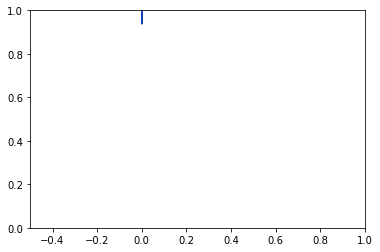

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

print(results.solver.status) 
print(results.solver.termination_condition) 

fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,1])
    ax.set_ylim([0,1])
    
    #plot link 1
    link1_top_x = m.X0.value 
    link1_top_z = m.Z0.value 
    link1_bottom_x = m.X0.value + 0.5*m.l1*sin(m.q0[i,'theta_1'].value)
    link1_bottom_z = m.Z0.value - 0.5*m.l1*cos(m.q0[i,'theta_1'].value)  
    ax.plot([link1_top_x,link1_bottom_x],[link1_top_z,link1_bottom_z],color='xkcd:black')
    
    #plot link 2  
    link2_bottom_x = link1_bottom_x + 0.5*m.l2*sin(m.q0[i,'theta_1'].value+m.q0[i,'theta_2'].value)
    link2_bottom_z = link1_bottom_z - 0.5*m.l2*sin(m.q0[i,'theta_1'].value+m.q0[i,'theta_2'].value)
    ax.plot([link1_bottom_x,link2_bottom_x],[link1_bottom_z,link2_bottom_z],color='xkcd:black')
    
    #plot link 3
    link3_top_x = m.X0.value 
    link3_top_z = m.Z0.value 
    link3_bottom_x = m.X0.value + 0.5*m.l3*sin(m.q0[i,'theta_3'].value)
    link3_bottom_z = m.Z0.value - 0.5*m.l3*cos(m.q0[i,'theta_3'].value)  
    ax.plot([link3_top_x,link3_bottom_x],[link3_top_z,link3_bottom_z],color='xkcd:blue')
    
    #plot link 4  
    link4_bottom_x = link3_bottom_x + 0.5*m.l4*sin(m.q0[i,'theta_3'].value+m.q0[i,'theta_4'].value)
    link4_bottom_z = link3_bottom_z - 0.5*m.l4*sin(m.q0[i,'theta_3'].value+m.q0[i,'theta_4'].value)
    ax.plot([link3_bottom_x,link4_bottom_x],[link3_bottom_z,link4_bottom_z],color='xkcd:blue')
       
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

HTML(animate.to_jshtml())